In [7]:
!pip install torchvision
!pip install --upgrade torchvision torch

  Using cached torchvision-0.23.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached torch-2.8.0-cp312-none-macosx_11_0_arm64.whl.metadata (30 kB)
Using cached torchvision-0.23.0-cp312-cp312-macosx_11_0_arm64.whl (1.9 MB)
Using cached torch-2.8.0-cp312-none-macosx_11_0_arm64.whl (73.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1━━━━━━ 0/2 [torch]
  Attempting uninstall: torchvision━━━━━━━━━━━━━ 0/2 [torch]
    Found existing installation: torchvision 0.19.132m0/2 [torch]
    Uninstalling torchvision-0.19.1:━━━━━━━━ 0/2 [torch]
      Successfully uninstalled torchvision-0.19.10/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
executorch 0.7.0 requires numpy>

In [1]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt


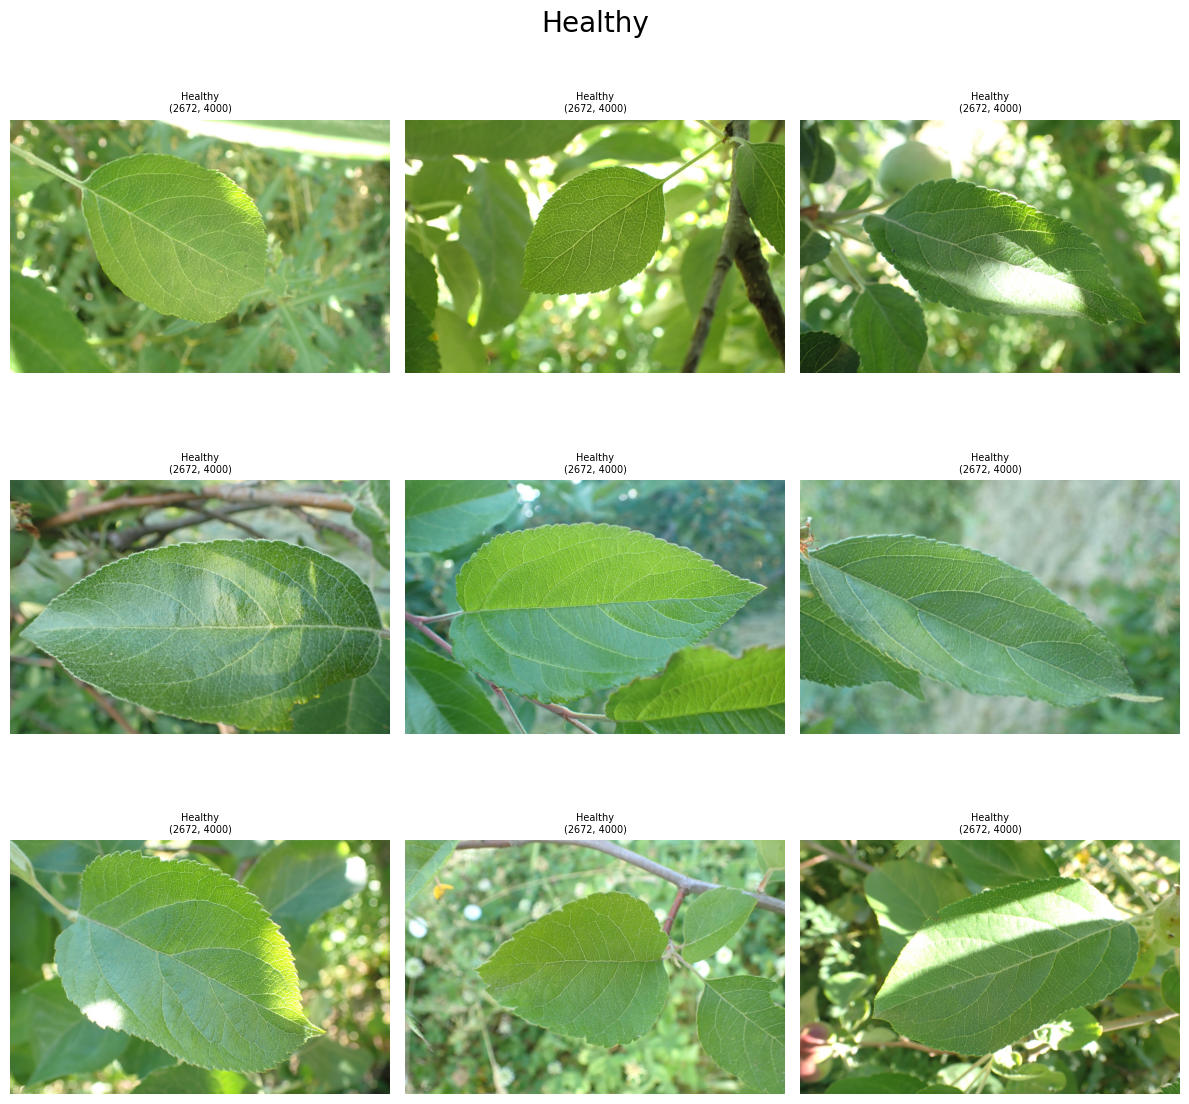

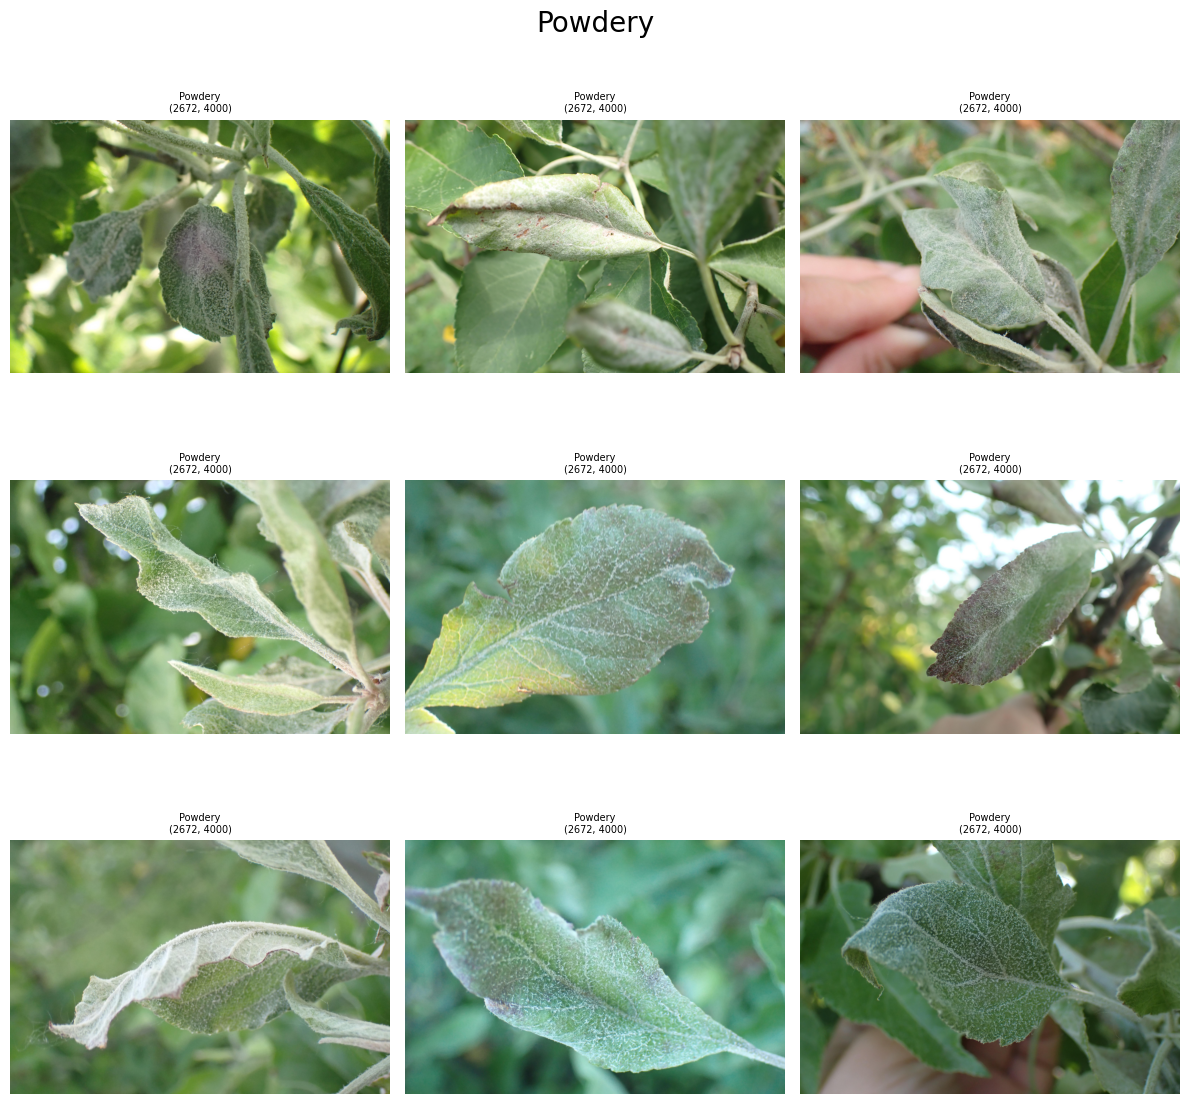

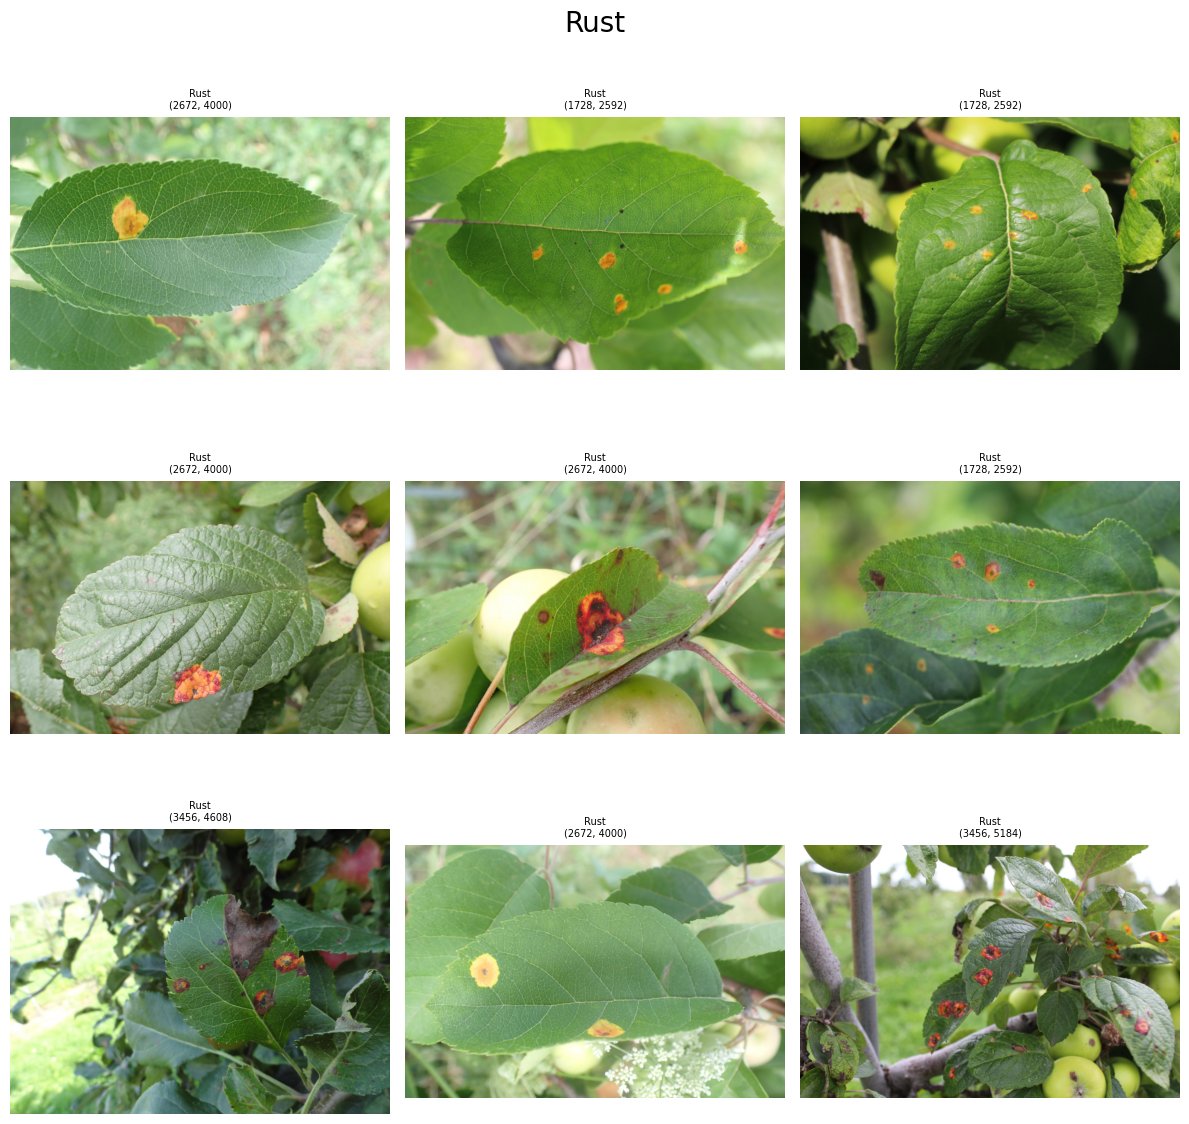

In [2]:
base_dir = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_plant_detection_dataset/kaggle_dataset/Train/Train"
classes = ["Healthy", "Powdery", "Rust"]

num_images = 9

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    
    selected_images = random.sample(images, min(num_images, len(images)))
    
    plt.figure(figsize=(12, 12))
    plt.suptitle(cls, fontsize=20)
    
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        shape_text = img.shape[:2]           
        
    
        
        plt.subplot(3, 3, i+1) 
        plt.imshow(img)
        plt.title(f"{cls}\n{shape_text}", fontsize=7)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [3]:
data_dir = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_plant_detection_dataset/kaggle_dataset/"

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # ResNet normalization
])

test_val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/Train/Train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/Validation/Validation", transform=test_val_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/Test/Test", transform=test_val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
num_classes = len(class_names)

In [4]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /Users/anushkaroy17/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:47<00:00, 2.41MB/s] 


Epoch 1/5 | Train Acc: 0.8525 | Val Acc: 0.9333
Epoch 2/5 | Train Acc: 0.9516 | Val Acc: 0.9667
Epoch 3/5 | Train Acc: 0.9697 | Val Acc: 0.9667
Epoch 4/5 | Train Acc: 0.9788 | Val Acc: 0.9833
Epoch 5/5 | Train Acc: 0.9743 | Val Acc: 0.9833


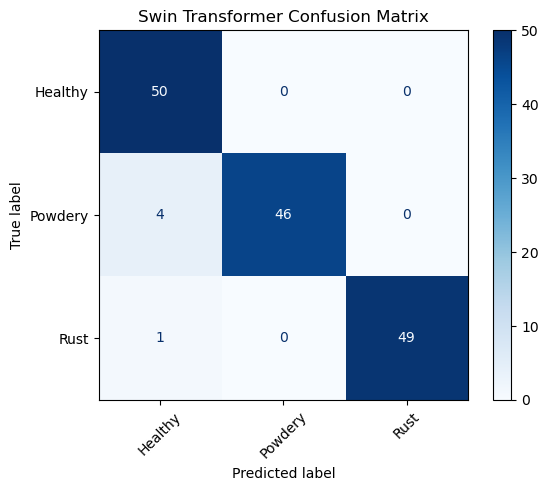

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      1.00      0.95        50
     Powdery       1.00      0.92      0.96        50
        Rust       1.00      0.98      0.99        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



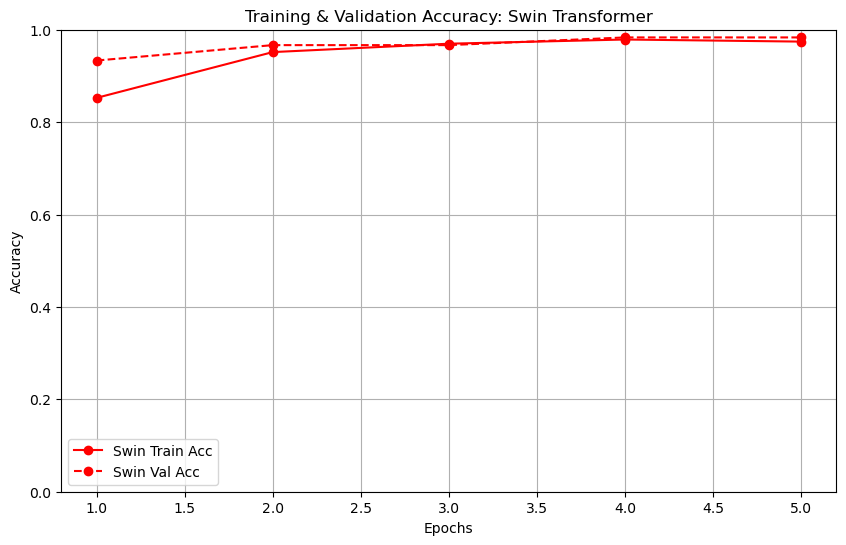

In [6]:
swin = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
for param in swin.parameters():
    param.requires_grad = False

num_classes = len(class_names) 
in_features = swin.head.in_features
swin.head = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)

swin = swin.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin.head.parameters(), lr=1e-3)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history
history = train_model(swin, criterion, optimizer, train_loader, val_loader, num_epochs=5)

swin.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = swin(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Swin Transformer Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

epochs = range(1, len(history["train_acc"]) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, history["train_acc"], 'r-o', label='Swin Train Acc')
plt.plot(epochs, history["val_acc"], 'r--o', label='Swin Val Acc')
plt.title("Training & Validation Accuracy: Swin Transformer")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
